# Your first simple tool

In the previous lesson we walked through the tool use workflow.  It's time to actually get to work implementing a simple example of tool use.  As a recap, there are up to 4 steps in the tool use process: 

1. **Provide Claude with tools and a user prompt:** (API request)
    * Define the set of tools you want Claude to have access to, including their names, descriptions, and input schemas.
    * Provide a user prompt that may require the use of one or more of these tools to answer.

2. **Claude uses a tool:** (API response)
    * Claude assesses the user prompt and decides whether any of the available tools would help with the user's query or task. If so, it also decides which tool(s) to use and with what input(s).
    * Claude outputs a properly formatted tool use request.
    * The API response will have a `stop_reason` of `tool_use`, indicating that Claude wants to use an external tool.

3. **Extract tool input(s), run code, and return results:** (API request)
    * On the client side, you should extract the tool name and input from Claude's tool use request.
    * Run the actual tool code on the client side.
    * Return the results to Claude by continuing the conversation with a new user message containing a `tool_result` content block.

4. **Claude uses the tool result to formulate a response:** (API response)
    * After receiving the tool results, Claude will use that information to formulate its final response to the original user prompt.

In [1]:
import boto3

bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

In [2]:
messages = [{
    "role": "user",
    "content": [{"text": "Multiply 1984135 by 9343116. Only respond with the result"}]
}]

inference_config={"maxTokens":400}

# Send the message.
response = bedrock_client.converse(
    modelId=model_id,
    messages=messages,
    inferenceConfig=inference_config,
)

In [3]:
def calculator(operation, operand1, operand2):
    if operation == "add":
        return operand1 + operand2
    elif operation == "subtract":
        return operand1 - operand2
    elif operation == "multiply":
        return operand1 * operand2
    elif operation == "divide":
        if operand2 == 0:
            raise ValueError("Cannot divide by zero.")
        return operand1 / operand2
    else:
        raise ValueError(f"Unsupported operation: {operation}")


In [4]:
calculator("multiply",1984135, 9343116)

18538003464660

### Our calculator tool definition
Let's define the corresponding tool for our calculator function we wrote earlier.  We know that the calculator function has 3 required arguments: 
* `operation` - which can only be "add", "subtract", "multiply", or "divide"
* `operand1` which should be a number
* `operand2` which should also be a number

Here's the tool definition:

In [5]:
calculator_tool = {
    "toolSpec": {
    "name": "calculator",
    "description": "A simple calculator that performs basic arithmetic operations.",
    "inputSchema": {
        "json": {
            "type": "object",
                "properties": {
                    "operation": {
                        "type": "string",
                        "enum": ["add", "subtract", "multiply", "divide"],
                        "description": "The arithmetic operation to perform."
                    },
                    "operand1": {
                        "type": "number",
                        "description": "The first operand."
                    },
                    "operand2": {
                        "type": "number",
                        "description": "The second operand."
                    }
                },
                "required": ["operation", "operand1", "operand2"]
            }
        }      
    }
}

### Providing Claude with our tool
Now back to our calculator function from earlier. At this point, Claude knows nothing about the calculator tool! It's just a little Python dictionary.  When making our request to Claude, we can pass a list of tools to "tell" Claude about.  Let's try it now:

In [6]:
messages = [{
    "role": "user",
    "content": [{"text": "Multiply 1984135 by 9343116. Only respond with the result"}]
}]

inference_config={"maxTokens":400}
tool_config = {"tools":[calculator_tool]}

# Send the message.
response = bedrock_client.converse(
    modelId=model_id,
    messages=messages,
    inferenceConfig=inference_config,
    toolConfig=tool_config,
)

Next, let's take a look at the response Claude gives us back:

In [7]:
response

{'ResponseMetadata': {'RequestId': 'b14ffd1a-bc1d-4c3c-9a1f-6430df41e7c6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 14 Nov 2024 19:23:51 GMT',
   'content-type': 'application/json',
   'content-length': '322',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'b14ffd1a-bc1d-4c3c-9a1f-6430df41e7c6'},
  'RetryAttempts': 0},
 'output': {'message': {'role': 'assistant',
   'content': [{'toolUse': {'toolUseId': 'tooluse_WuZT0fT3RweHPlnhvLpxJA',
      'name': 'calculator',
      'input': {'operation': 'multiply',
       'operand1': 1984135,
       'operand2': 9343116}}}]}},
 'stopReason': 'tool_use',
 'usage': {'inputTokens': 469, 'outputTokens': 93, 'totalTokens': 562},
 'metrics': {'latencyMs': 1587}}

In [8]:
response['stopReason']

'tool_use'

In [9]:
response['output']

{'message': {'role': 'assistant',
  'content': [{'toolUse': {'toolUseId': 'tooluse_WuZT0fT3RweHPlnhvLpxJA',
     'name': 'calculator',
     'input': {'operation': 'multiply',
      'operand1': 1984135,
      'operand2': 9343116}}}]}}

In [10]:
tool_requests = response['output']['message']['content'][0]['toolUse']


tool_name = tool_requests["name"]
tool_inputs = tool_requests["input"]

print("The Tool Name Claude Wants To Call:", tool_name)
print("The Inputs Claude Wants To Call It With:", tool_inputs)

The Tool Name Claude Wants To Call: calculator
The Inputs Claude Wants To Call It With: {'operation': 'multiply', 'operand1': 1984135, 'operand2': 9343116}


`response.content` contains a list containing a `ToolUseBlock` which itself contains information on the name of the tool and inputs:

In [11]:
operation = tool_inputs["operation"]
operand1 = tool_inputs["operand1"]
operand2 = tool_inputs["operand2"]

result = calculator(operation, operand1, operand2)
print("RESULT IS", result)

RESULT IS 18538003464660


We got the correct answer of `18538003464660`!!! Instead of relying on Claude to get the math correct, we simply ask Claude a question and give it access to a tool it can decide to use if necessary.  

#### Important note
If we ask Claude something that does not require tool use, in this case something that has nothing to do with math or calculations, we probably want it to respond as normal. Claude will usually do this, but sometimes Claude is very eager to use its tools! 

Here's an example where sometimes Claude tries to use the calculator even though it doesn't make sense to use it. Let's see what happens when we ask Claude, "What color are emeralds?"

The next step is to simply take the tool name and inputs that Claude provided us with and use them to actually call the calculator function we wrote earlier.  Then we'll have our final answer! 

In [12]:
messages = [{
    "role": "user",
    "content": [{"text": "Multiply 1984135 by 9343116. Only respond with the result"}]
}]

inference_config={"maxTokens":400}
tool_config = {"tools":[calculator_tool]}

# Send the message.
response = bedrock_client.converse(
    modelId=model_id,
    messages=messages,
    inferenceConfig=inference_config,
    toolConfig=tool_config,
)

In [13]:
response

{'ResponseMetadata': {'RequestId': 'fd808949-f573-4d19-a6b7-7ee3e7bb6aa9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 14 Nov 2024 19:23:53 GMT',
   'content-type': 'application/json',
   'content-length': '322',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'fd808949-f573-4d19-a6b7-7ee3e7bb6aa9'},
  'RetryAttempts': 0},
 'output': {'message': {'role': 'assistant',
   'content': [{'toolUse': {'toolUseId': 'tooluse_urHoc59wRCCBdYy5-g_ZRA',
      'name': 'calculator',
      'input': {'operation': 'multiply',
       'operand1': 1984135,
       'operand2': 9343116}}}]}},
 'stopReason': 'tool_use',
 'usage': {'inputTokens': 469, 'outputTokens': 93, 'totalTokens': 562},
 'metrics': {'latencyMs': 1821}}

In [14]:
messages = [{
    "role": "user",
    "content": [{"text": "Why is the earth round?"}]
}]

inference_config={"maxTokens":400}
tool_config = {"tools":[calculator_tool]}

# Send the message.
response = bedrock_client.converse(
    modelId=model_id,
    messages=messages,
    system=[{"text": "You have access to tools, but only use them when necessary.  If a tool is not required, respond as normal"}],
    inferenceConfig=inference_config,
    toolConfig=tool_config,
)

In [15]:
response

{'ResponseMetadata': {'RequestId': 'ca04ab66-73d1-4524-9696-be1bdf49a044',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 14 Nov 2024 19:24:01 GMT',
   'content-type': 'application/json',
   'content-length': '1459',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'ca04ab66-73d1-4524-9696-be1bdf49a044'},
  'RetryAttempts': 0},
 'output': {'message': {'role': 'assistant',
   'content': [{'text': "The Earth is round (technically an oblate spheroid) due to fundamental physics, not because of a calculation, so I'll explain without using any tools.\n\nThe Earth's spherical shape is primarily due to gravity. Here's why:\n\n1. Gravitational force: When the Earth was forming billions of years ago, matter was pulled together by mutual gravitational attraction. This force pulls equally from all directions toward the center of mass.\n\n2. Hydrostatic equilibrium: When an object is massive enough, its own gravity overcomes the rigid forces in the material it's made of. This causes 

In [16]:
response['stopReason']

'end_turn'

***

### Putting it all together

In [17]:
def calculator(operation, operand1, operand2):
    if operation == "add":
        return operand1 + operand2
    elif operation == "subtract":
        return operand1 - operand2
    elif operation == "multiply":
        return operand1 * operand2
    elif operation == "divide":
        if operand2 == 0:
            raise ValueError("Cannot divide by zero.")
        return operand1 / operand2
    else:
        raise ValueError(f"Unsupported operation: {operation}")


calculator_tool = {
    "toolSpec": {
    "name": "calculator",
    "description": "A simple calculator that performs basic arithmetic operations.",
    "inputSchema": {
        "json": {
             "type": "object",
        "properties": {
            "operation": {
                "type": "string",
                "enum": ["add", "subtract", "multiply", "divide"],
                "description": "The arithmetic operation to perform."
            },
            "operand1": {
                "type": "number",
                "description": "The first operand."
            },
            "operand2": {
                "type": "number",
                "description": "The second operand."
            }
        },
        "required": ["operation", "operand1", "operand2"]
        }
 }      
    }
}


def prompt_claude(prompt):

    messages = [{
        "role": "user",
        "content": [{"text": prompt}]
    }]

    inference_config={"maxTokens":400}
    tool_config = {"tools":[calculator_tool]}

    # Send the message.
    response = bedrock_client.converse(
        modelId=model_id,
        messages=messages,
        inferenceConfig=inference_config,
        toolConfig=tool_config,
    )
    stop_reason = response['stopReason']

    if stop_reason == 'tool_use':
        # Tool use requested. Call the tool and send the result to the model.

        msg = {
            "role": "assistant",
            "content": [{"text": response['output']['message']["content"][0]["text"]}]
        }

        messages.append(msg)
        
        tool_requests = response['output']['message']['content'][-1]
        if response["stopReason"] == "tool_use":
            tool = tool_requests['toolUse']

            if tool['name'] == 'calculator':
                result = calculator(tool['input']['operation'], tool['input']['operand1'], tool['input']['operand2'])
                print("Calculation result is:", result)

           
    elif stop_reason== "end_turn":
        print("result is:", response['output']['message']['content'][0]["text"])
        

In [18]:
prompt_claude("I had 23 chickens but 2 flew away.  How many are left?")

Calculation result is: 21


In [19]:
prompt_claude("What is 201 times 2")

Calculation result is: 402


In [ ]:
prompt_claude("Write me a haiku about the ocean")

*** 

## Exercise

Your task is to help build out a research assistant using Claude.  A user can enter a topic that they want to research and get a list of Wikipedia article links saved to a markdown file for later reading. We could try asking Claude directly to generate a list of article URLs, but Claude is unreliable with URLs and may hallucinate article URLs. Also, legitimate articles might have moved to a new URL after Claude's training cutoff date.  Instead, we're going to use a tool that connects to the real Wikipedia API to make this work! 

We'll provide Claude with access to a tool that accepts a list of possible Wikipedia article titles that Claude has generated but could have hallucinated. We can use this tool to search Wikipedia to find the actual Wikipedia article titles and URLs to ensure that the final list consists of articles that all actually exist. We’ll then save these article URLs to a markdown file for later reading.

We've provided you with two functions to help:


In [ ]:
import wikipedia
def generate_wikipedia_reading_list(research_topic, article_titles):
    wikipedia_articles = []
    for t in article_titles:
        results = wikipedia.search(t)
        try:
            page = wikipedia.page(results[0])
            title = page.title
            url = page.url
            wikipedia_articles.append({"title": title, "url": url})
        except:
            continue
    add_to_research_reading_file(wikipedia_articles, research_topic)

def add_to_research_reading_file(articles, topic):
    with open("output/research_reading.md", "a", encoding="utf-8") as file:
        file.write(f"## {topic} \n")
        for article in articles:
            title = article["title"]
            url = article["url"]
            file.write(f"* [{title}]({url}) \n")
        file.write(f"\n\n")

The first function, `generate_wikipedia_reading_list` expects to be passed a research topic like "The history of Hawaii" or "Pirates across the world" and a list of potential Wikipedia article names that we will have Claude generate.  The function uses the `wikipedia` package to search for corresponding REAL wikipedia pages and builds a list of dictionaries that contain an article's title and URL.

Then it calls `add_to_research_reading_file`, passing in the list of Wikipedia article data and the overall research topic.  This function simply adds markdown links to each of the Wikipedia articles to a file called `output/research_reading.md`.  The filename is hardcoded for now, and the function assumes it exists. It exists in this repo, but you'll need to create it yourself if working somewhere else.

The idea is that we'll have Claude "call" `generate_wikipedia_reading_list` with a list of potential article titles that may or may not be real.  Claude might pass the following input list of article titles, some of which are real Wikipedia articles and some of which are not:

```py
["Piracy", "Famous Pirate Ships", "Golden Age Of Piracy", "List of Pirates", "Pirates and Parrots", "Piracy in the 21st Century"]
```

The `generate_wikipedia_reading_list` function goes through each of those article titles and collects the real article titles and corresponding URLs for any Wikipedia articles that actually exist.  It then calls `add_to_research_reading_file` to write that content to a markdown file for later reference.

### The end goal

Your job is to implement a function called `get_research_help` that accepts a research topic and a desired number of articles. This function should use Claude to actually generate the list of possible Wikipedia articles and call the `generate_wikipedia_reading_list` function from above.  Here are a few example function calls:

```py
get_research_help("Pirates Across The World", 7)

get_research_help("History of Hawaii", 3)

get_research_help("are animals conscious?", 3)
```

After these 3 function calls, this is what our output `research_reading.md` file looks like (check it out for yourself in output/research_reading.md): 

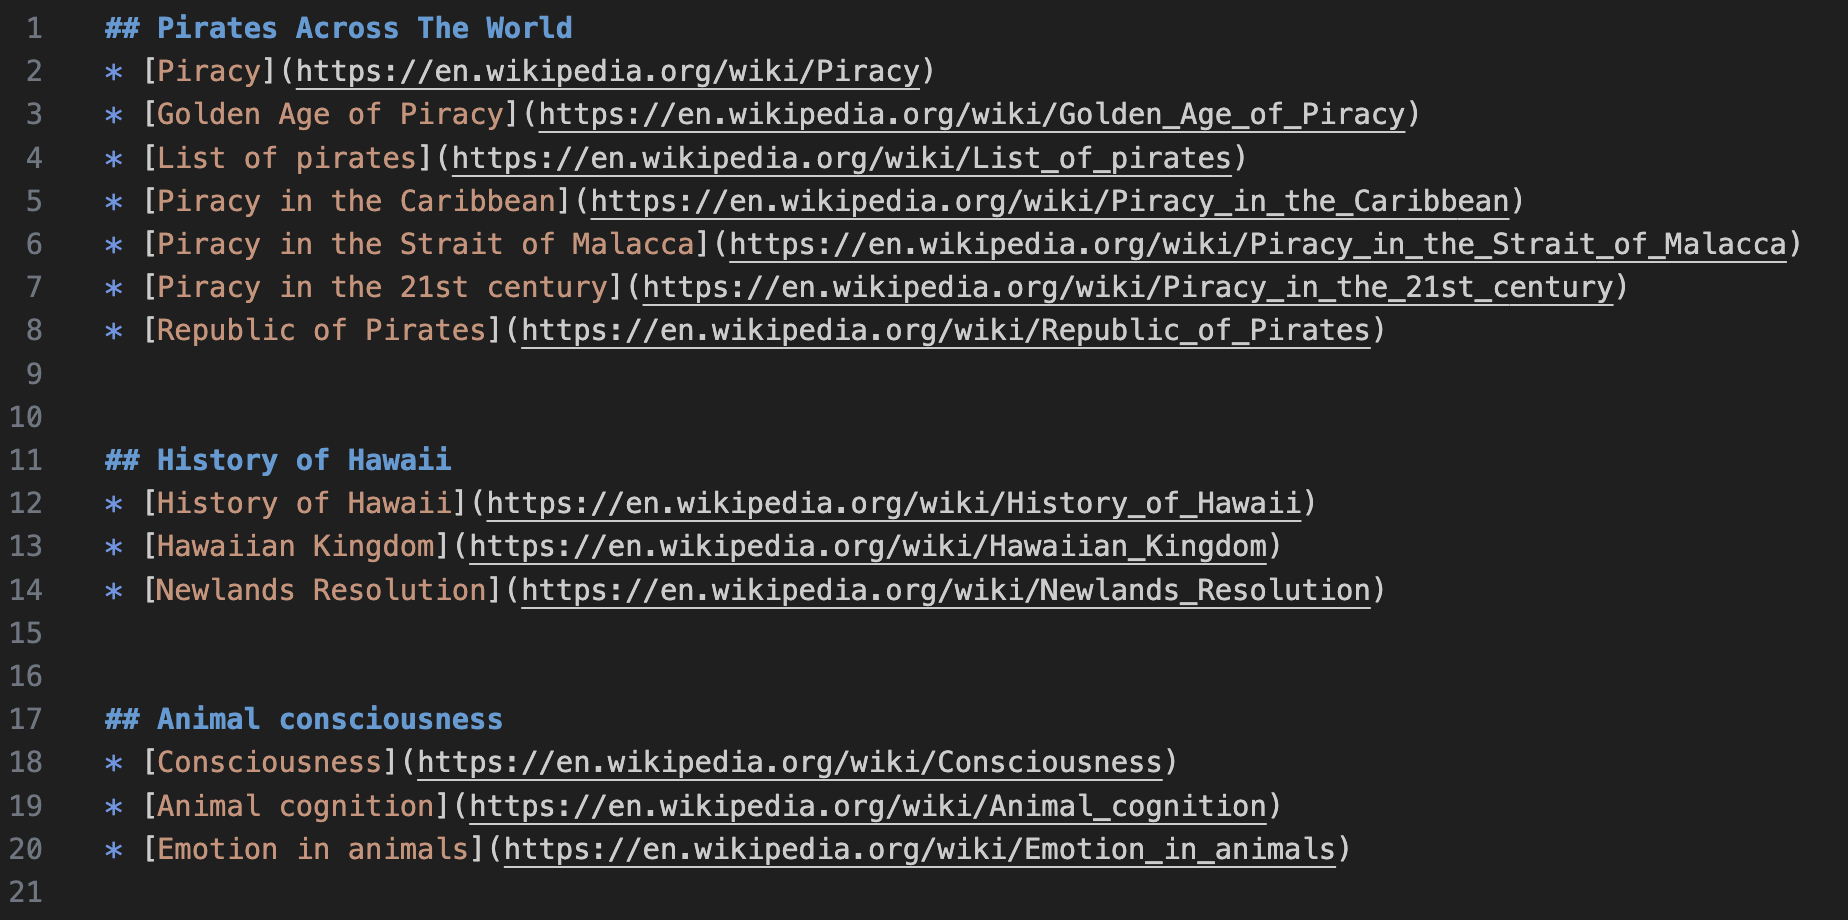



To accomplish this, you'll need to do the following: 

* Write a tool definition for the `generate_wikipedia_reading_list` function
* Implement the `get_research_help` function
    * Write a prompt to Claude telling it that you need help gathering research on the specific topic and how many article titles you want it to generate
    * Tell Claude about the tool it has access to
    * Send off your request to Claude
    * Check to see if Claude called the tool.  If it did, you'll need to pass the article titles and topic it generated to the `generate_wikipedia_reading_list` function we gave you. That function will gather actual Wikipedia article links and then call `add_to_research_reading_file` to write the links to `output/research_reading.md`
    * Open `output/research_reading.md` to see if it worked!


##### Starter Code

In [ ]:
# Here's your starter code!
import wikipedia
def generate_wikipedia_reading_list(research_topic, article_titles):
    wikipedia_articles = []
    for t in article_titles:
        results = wikipedia.search(t)
        try:
            page = wikipedia.page(results[0])
            title = page.title
            url = page.url
            wikipedia_articles.append({"title": title, "url": url})
        except:
            continue
    add_to_research_reading_file(wikipedia_articles, research_topic)

def add_to_research_reading_file(articles, topic):
    with open("output/research_reading.md", "a", encoding="utf-8") as file:
        file.write(f"## {topic} \n")
        for article in articles:
            title = article["title"]
            url = article["url"]
            file.write(f"* [{title}]({url}) \n")
        file.write(f"\n\n")
        
def get_research_help(topic, num_articles=3):
   #Implement this function! 
   pass